# Code to Replicate Best-Performing CNN

In [1]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

project_root_dir = 'insert_root_directory_location_here'

## 1. Network architecture

In [ ]:
keras.backend.clear_session()

The Xception architecture generally yielded the best-performing models. We load this using keras.

In [4]:
base_model = keras.applications.xception.Xception(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

The following code allows one to define the classification module for the pretrained network as described in the paper.

In [5]:
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D

def pretrained_model_builder(base_model, n_classes = 3, dropout_factor = 0.5, regularization_factor = 0.0, fc_layers = [1024, 1024], use_global_pool = False):
    """
    Build a pretrained model according on top of a base network imported from keras.
    
    Args:
        base_model: pre-trained network
        n_classes: number of output classes (3 for the AQI task)
        dropout_factor: dropout probability
        regularization_factor: coefficient for L2 regularization
        fc_layers: list of fully connected layers; elements of the list should be the number of hidden units per layer.
        use_global_pool: boolean to decide whether or not to use global average pool as the output. If true, replaces fc layers as output.
        
    Returns:
        A keras model built with the specified classification module on top of the pretrained network.
    """
    
    base_output = base_model.output

    if use_global_pool == False:
        x = Flatten()(base_output)
        for fc in fc_layers:
            x = Dense(fc, use_bias = False, kernel_regularizer = keras.regularizers.l2(regularization_factor))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(dropout_factor)(x)
        
        x = Dense(n_classes, use_bias = False)(x)
        x = BatchNormalization()(x)
        preds = Activation('softmax')(x)

    elif use_global_pool == True:
        x = GlobalAveragePooling2D()(base_output)
        preds = Dense(n_classes, activation = 'softmax')(x)

    model = keras.Model(inputs = base_model.input, outputs = preds)
    return model

We now implement the best-performing model.

In [6]:
model = pretrained_model_builder(base_model, n_classes = 3, dropout_factor = 0.3, regularization_factor = 0.0, fc_layers = [1024, 1024])

In [7]:
for layer in base_model.layers:
  layer.trainable = False

All experiments in this project were performed using Google Colab. We encountered problems with training time when using batch training with the images loaded in real time from directories. Hence, we converted the training, test, and validation sets to compressed numpy arrays and loaded them as needed during training with careful memory management.

In [8]:
train = np.load(os.path.join(experiments_dir, 'train.npz'))
valid = np.load(os.path.join(experiments_dir, 'valid.npz'))
test = np.load(os.path.join(experiments_dir, 'test.npz'))

The following shows a few of the images from the training set.

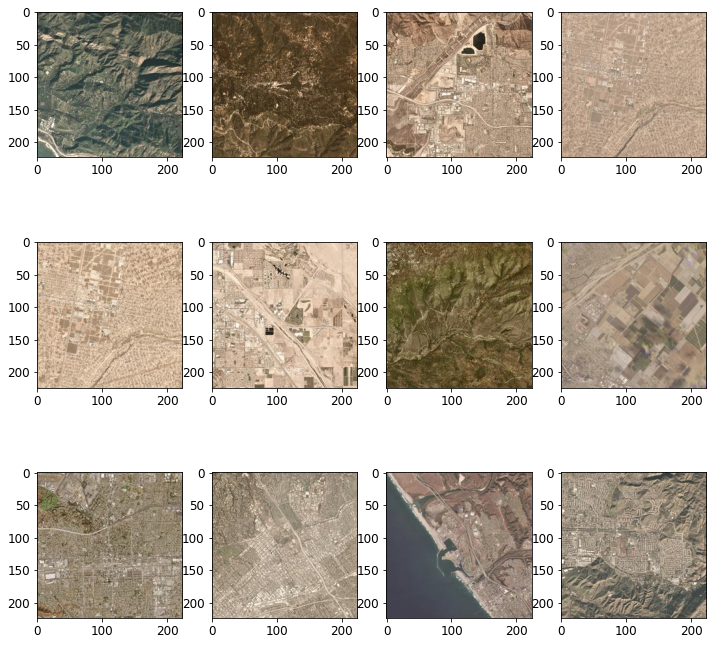

In [ ]:
n_row = 3
n_col = 4

random_idx = np.random.choice(x_train.shape[0], n_row * n_col)
imgs = x_train[random_idx, :, :, :]/255

_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

## 2. First round of training

We now implement the first round of staged training. First, we define the weights for the weighted loss using the formula
$$w_{y^{(i)}} = \frac{\textit{# samples in largest class}}{\textit{# samples in class } y^{(i)}}$$

In [9]:
from collections import Counter
item_ct = Counter(train['y'])
max_ct = float(max(item_ct.values()))
class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}

This first round of training utilizes a large learning rate to adjust the classification layers.

In [10]:
optimizer = keras.optimizers.SGD(lr = 0.2)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [11]:
# Manual garbage collection
collect()

15

We now load the training and validation sets, and preprocess them for the Xception base.

In [ ]:
batch_size = 16
epochs = 5

x_train_scaled = keras.applications.xception.preprocess_input(train['x'])
x_valid_scaled = keras.applications.xception.preprocess_input(valid['x'])

n_train = x_train_scaled.shape[0]

In [13]:
history = model.fit(x_train_scaled, train['y'], epochs = epochs, batch_size = batch_size,
                    validation_data = (x_valid_scaled, valid['y']),
                    class_weight = class_wts)

Epoch 1/5
209/209 [==============================] - 26s 122ms/step - loss: 1.5999 - accuracy: 0.5341 - val_loss: 0.9890 - val_accuracy: 0.5572
Epoch 2/5
209/209 [==============================] - 24s 113ms/step - loss: 1.4246 - accuracy: 0.6040 - val_loss: 0.8366 - val_accuracy: 0.6103
Epoch 3/5
209/209 [==============================] - 23s 111ms/step - loss: 1.3412 - accuracy: 0.6358 - val_loss: 0.8031 - val_accuracy: 0.6382
Epoch 4/5
209/209 [==============================] - 23s 111ms/step - loss: 1.2971 - accuracy: 0.6478 - val_loss: 0.9089 - val_accuracy: 0.6004
Epoch 5/5
209/209 [==============================] - 23s 112ms/step - loss: 1.2223 - accuracy: 0.6667 - val_loss: 0.9251 - val_accuracy: 0.6058


## 3. Preparation for Second Round of Training

### 3.1 Unfreeze final layers

First, we freeze the final 32 layers of the Xception base.

In [15]:
for layer in base_model.layers[-32:]:
  layer.trainable = True

In [16]:
# Manual garbage collection
collect()

1806

### 3.2 1-Cycle Learning Rate Scheduling

The best-performing model employed 1-Cycle learning rate scheduling. The code to implement this Learning Rate schedule is from _Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow_ (2 ed.) by Geron, chapter 10.

In [17]:
# Learning rate model

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [18]:
# Learning rate search

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs = epochs, batch_size = batch_size,
                        callbacks=[exp_lr],
                        class_weight = class_wts)
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [19]:
# Plotting

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [20]:
# Compile the model

tf.random.set_seed(123)
np.random.seed(123)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

209/209 [==============================] - 27s 129ms/step - loss: 1.8376 - accuracy: 0.5629


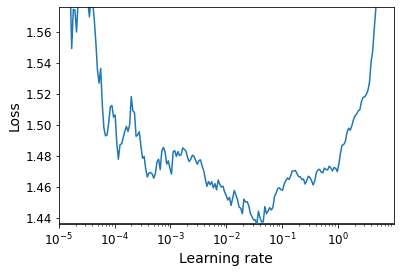

In [21]:
rates, losses = find_learning_rate(model, x_train_scaled, train['y'], epochs = 1, batch_size = batch_size)
plot_lr_vs_loss(rates, losses)

In [22]:
best_rate = rates[np.argmin(losses)]
best_rate

0.03532454

In [23]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate = None,
                 last_iterations = None, last_rate = None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [24]:
# Manual garbage collection
collect()

10224

## 4. Second round of fitting

We now perform a second round of fitting with the final base layers unfrozen.

In [25]:
epochs = 25
onecycle = OneCycleScheduler(n_train // batch_size * epochs, max_rate = best_rate)

history = model.fit(x_train_scaled, train['y'], epochs = epochs, batch_size = batch_size,
                    validation_data = (x_valid_scaled, valid['y']),
                    callbacks = [onecycle],
                    class_weight = class_wts)

Epoch 1/25
209/209 [==============================] - 33s 156ms/step - loss: 1.2987 - accuracy: 0.6388 - val_loss: 0.9895 - val_accuracy: 0.5689
Epoch 2/25
209/209 [==============================] - 31s 149ms/step - loss: 1.1290 - accuracy: 0.6964 - val_loss: 0.9129 - val_accuracy: 0.6094
Epoch 3/25
209/209 [==============================] - 31s 147ms/step - loss: 1.0509 - accuracy: 0.7264 - val_loss: 0.9424 - val_accuracy: 0.6085
Epoch 4/25
209/209 [==============================] - 31s 148ms/step - loss: 0.9254 - accuracy: 0.7621 - val_loss: 0.9509 - val_accuracy: 0.6085
Epoch 5/25
209/209 [==============================] - 31s 148ms/step - loss: 0.8268 - accuracy: 0.7900 - val_loss: 0.8945 - val_accuracy: 0.6049
Epoch 6/25
209/209 [==============================] - 31s 148ms/step - loss: 0.7453 - accuracy: 0.8149 - val_loss: 0.9621 - val_accuracy: 0.6238
Epoch 7/25
209/209 [==============================] - 31s 148ms/step - loss: 0.6638 - accuracy: 0.8497 - val_loss: 1.0490 - val_ac

It would appear that this model is overfitting quite strongly to the training set, although it does get high performance on the validation set.

# 5. Evaluation

Lastly, we evaluate on the test set. The following function allowed us to keep track of results from repeated experiments.

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def model_eval(directory_name, model, history, x_test_scaled, y_test, x_valid_scaled, y_valid):
    """
    Save evaluation plots to a specified directory.
    
    Args:
        directory_name: name of directory where plots and eval data will be saved
        model: final model used for evaluation
        history: history of model performance
        x_test_scaled, y_test: test data
        x_valid_scaled, y_valid: validation data
        
    Returns:
        A directory with loss curves, accuracy curves, and test/validation confusion matrices.
    """
    
    # First, make the directory
    directory_name = os.path.join(experiments_dir, 'model_results', directory_name)
    os.mkdir(directory_name)
    
    # Evaluation data and predictions
    test_eval_data, valid_eval_data = model.evaluate(x_test_scaled, y_test), model.evaluate(x_valid_scaled, y_valid)
    test_preds, valid_preds = model.predict(x_test_scaled), model.predict(x_valid_scaled)
    test_pred_classes, valid_pred_classes = test_preds.argmax(axis = -1), valid_preds.argmax(axis = -1)

    # Generate confusion matrices
    test_cf_matrix = confusion_matrix(y_test, test_pred_classes)
    valid_cf_matrix = confusion_matrix(y_valid, valid_pred_classes)

    # Test confusion matrix
    ax = plt.subplot()
    sns.heatmap(test_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
    plt.title('Confusion matrix: test set')
    plt.savefig(os.path.join(directory_name, 'test_set_cf_matrix.png'))
    plt.show()

    # Validation confusion matrix
    ax = plt.subplot()
    sns.heatmap(valid_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
    plt.title('Confusion matrix: valid set')
    plt.savefig(os.path.join(directory_name, 'valid_set_cf_matrix.png'))
    plt.show()

    # Plot of model accuracy vs. epoch
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy v. epoch')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc = 'lower right')
    plt.savefig(os.path.join(directory_name, 'accuracy_plot.png'))
    plt.show()

    # Plot of model loss vs. epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss v. epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.savefig(os.path.join(directory_name, 'cross_entropy_loss_plot.png'))
    plt.show()

    # Saves final .csv with test and validation performance
    eval_df = pd.DataFrame(columns = ['set', 'loss', 'accuracy'])
    eval_df.loc[0] = ['test', test_eval_data[0], test_eval_data[1]]
    eval_df.loc[1] = ['valid', valid_eval_data[0], valid_eval_data[1]]
    eval_df.to_csv(os.path.join(directory_name, 'eval_df.csv'))

In [28]:
# Manual garbage collection
collect()

925

In [29]:
# To save memory on Colab
del x_train_scaled

In [ ]:
# Load in and preprocess the test data
x_test_scaled = keras.applications.xception.preprocess_input(test['x'])

35/35 [==============================] - 5s 145ms/step - loss: 1.1778 - accuracy: 0.6463


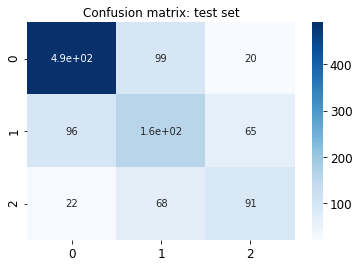

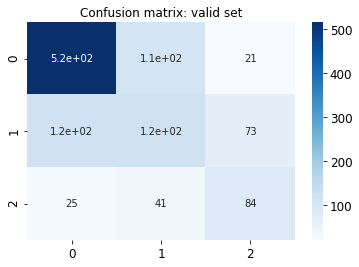

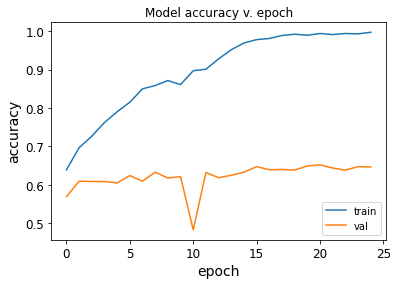

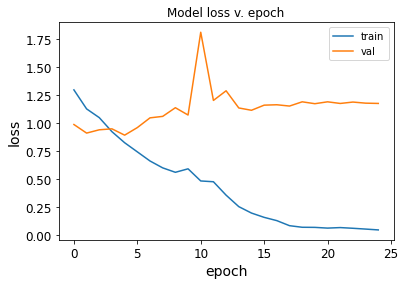

In [31]:
# Run the evaluation function
model_eval('11-17-20_xception_fc_1024_1024_dropout_0.3_reg_0.0_Staged_SGD0.2_1Cycle_0.035', model, history, x_test_scaled, test['y'], x_valid_scaled, valid['y'])

In conclusion, we see that a quite rocky training performance yielded one of the best test results. This is likely due to the uncertainty involving our small dataset and variation in image quality throughout this set. With increased training data and a more detailed hyperparameter search, and even better model performance could likely be reached, possibly surpassing our 70% goal performance.